In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# --- EfficientNetB5 Imports ---
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Configuration
IMG_SIZE = (456, 456)  # B5 requires 456x456
BATCH_SIZE = 16        # Keep 16 or 8 to avoid Out of Memory (OOM)

TensorFlow Version: 2.18.0
Num GPUs Available:  1


In [ ]:
!pip install protobuf==3.20.3

In [8]:
# 1. Define Paths
try:
    train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
    img_dir = '../input/aptos2019-blindness-detection/train_images/'
except FileNotFoundError:
    print("❌ Error: Dataset path not found. Please add the APTOS 2019 dataset to Kaggle.")

# 2. Add Extensions & Convert Types
train_df['id_code'] = train_df['id_code'].apply(lambda x: x + ".png")
train_df['diagnosis'] = train_df['diagnosis'].astype(str)

# 3. Stratified Split
train_set, val_set = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['diagnosis']
)

print(f"✅ Data Loaded. Train Size: {len(train_set)}, Validation Size: {len(val_set)}")

✅ Data Loaded. Train Size: 2929, Validation Size: 733


In [9]:
# Training Generator (Augmentation enabled)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Validation Generator (No Augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    directory=img_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=IMG_SIZE
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_set,
    directory=img_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=IMG_SIZE
)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [10]:
def create_model():
    # Download weights for B5
    print("Downloading EfficientNetB5 weights...")
    base_model = EfficientNetB5(
        weights='imagenet', 
        include_top=False, 
        input_shape=(456, 456, 3)
    )
    
    # Freeze the first blocks if you want, but for now we train all (fine-tuning)
    # base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Low learning rate for B5
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    return model

model = create_model()
print("✅ EfficientNetB5 Model Created Successfully!")

✅ EfficientNetB5 Model Created Successfully!


In [11]:
# 1. Calculate Class Weights (To handle imbalance)
train_classes = train_generator.classes
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights_vals))
print("⚖️ Class Weights:", class_weights_dict)

# 2. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model_b5.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# 3. Start Training
print("🚀 Starting Training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights_dict
)

⚖️ Class Weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}
🚀 Starting Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 18/184 ━━━━━━━━━━━━━━━━━━━━ 7:46 3s/step - accuracy: 0.3767 - loss: 1.7004

E0000 00:00:1764228066.204751     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764228066.381929     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764228066.887036     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764228067.091252     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764228067.481228     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5371 - loss: 1.3824
Epoch 1: val_accuracy improved from -inf to 0.64120, saving model to best_model_b5.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.5375 - loss: 1.3814 - val_accuracy: 0.6412 - val_loss: 0.8091 - learning_rate: 1.0000e-04
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6937 - loss: 0.9103
Epoch 2: val_accuracy improved from 0.64120 to 0.78445, saving model to best_model_b5.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.6937 - loss: 0.9105 - val_accuracy: 0.7844 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7509 - loss: 0.7894
Epoch 3: val_accuracy did not improve from 0.78445
184/184 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - accuracy: 0.7509 - loss: 0.7893 - val_accuracy: 0.7012 - val_loss: 0.7668 - learning_rate: 1.0000e-04
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7785 - loss: 0.7393
E

In [14]:
# --- LOAD BEST MODEL ---
from tensorflow.keras.models import load_model

print("💾 Loading the Best Model (Epoch 10 - 80% Accuracy)...")
# Humne checkpoint mein 'best_model_b5.keras' naam rakha tha
model = load_model('best_model_b5.keras') 

print("✅ Best model loaded! Ab Evaluation run karein.")

💾 Loading the Best Model (Epoch 10 - 80% Accuracy)...
✅ Best model loaded! Ab Evaluation run karein.


Found 733 validated image filenames belonging to 5 classes.
Generating Predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        No DR       0.97      0.97      0.97       361
         Mild       0.53      0.73      0.61        74
     Moderate       0.83      0.64      0.72       200
       Severe       0.34      0.56      0.43        39
Proliferative       0.62      0.58      0.60        59

     accuracy                           0.80       733
    macro avg       0.66      0.69      0.67       733
 weighted avg       0.83      0.80      0.81       733



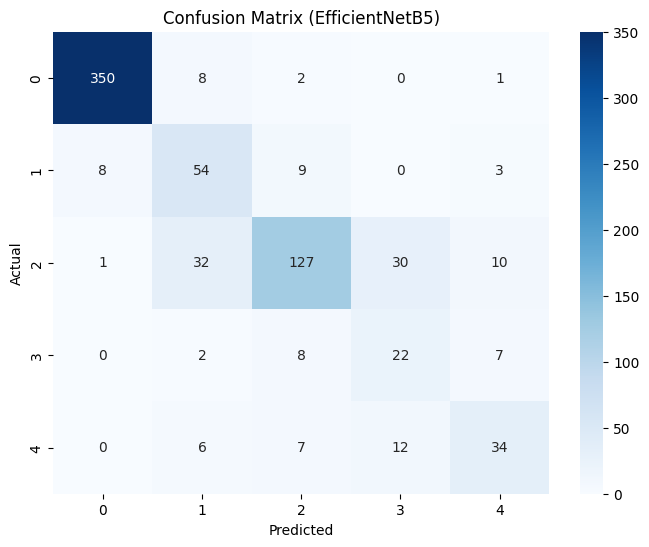

In [15]:
# 1. Re-create Validation Generator with Shuffle=False for evaluation
test_generator = val_datagen.flow_from_dataframe(
    dataframe=val_set,
    directory=img_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=IMG_SIZE,
    shuffle=False  # IMPORTANT: Must be False for confusion matrix
)

# 2. Predict
print("Generating Predictions...")
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# 3. Classification Report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']))

# 4. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (EfficientNetB5)')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 456, 456, 3))
  warnings.warn(msg)
/tmp/ipykernel_47/2949300480.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


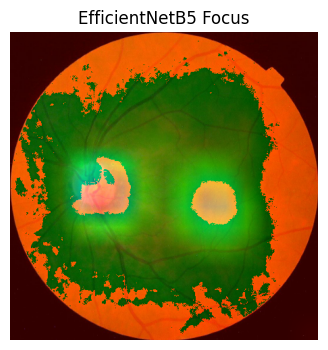

True Class: 0


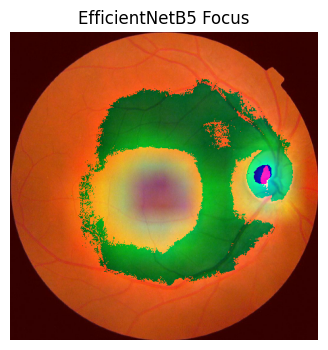

True Class: 0


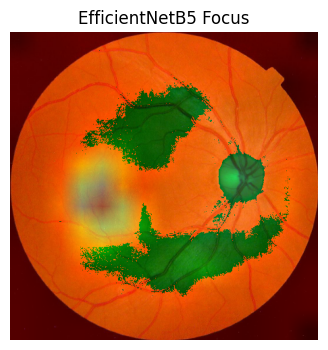

True Class: 0


In [16]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (456, 456)) # Resize to B5 size
    
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(jet_heatmap * 255)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("EfficientNetB5 Focus")
    plt.show()

# Run Grad-CAM
# EfficientNet last layer is usually 'top_activation'
last_conv_layer_name = "top_activation" 

import random
random_indices = random.sample(range(len(test_generator.filenames)), 3)

for i in random_indices:
    img_path = img_dir + test_generator.filenames[i]
    original = cv2.imread(img_path)
    original = cv2.resize(original, (456, 456))
    img_array = preprocess_input(original)
    img_array = np.expand_dims(img_array, axis=0)
    
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        display_gradcam(img_path, heatmap)
        print(f"True Class: {test_generator.classes[i]}")
    except Exception as e:
        print(f"Skipping image due to error: {e}")

In [17]:
# Is code ko copy kar ke naye cell mein run karein
from IPython.display import FileLink

# Yeh aapko download link bana kar de dega
print("Neeche diye gaye link par click karein:")
display(FileLink(r'best_model_b5.keras'))

Neeche diye gaye link par click karein:


/kaggle/working/best_model_b5.keras

In [18]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.4
    Uninstalling pydantic-2.12.4:
      Successfully uninstalled pydantic-2.12.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.cm as cm
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. Model Load karna
try:
    model = load_model('best_model_b5.keras')
    print("✅ Model Loaded!")
except:
    print("⚠️ Model file 'best_model_b5.keras' nahi mili.")

# Class Names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# --- GRAD-CAM HELPER FUNCTIONS ---
def get_img_array(img_path, size):
    # Gradio se image direct array main ati hai, isliye path ki zaroorat nahi
    img = cv2.resize(img_path, size)
    array = np.expand_dims(img, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_activation", pred_index=None):
    # Model ke andar se layers nikalna
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- MAIN PREDICTION FUNCTION ---
def predict_with_gradcam(image):
    if image is None:
        return None, None
    
    # 1. Image Prep for Model (456x456 for B5)
    original_img = cv2.resize(image, (456, 456))
    img_array = preprocess_input(np.expand_dims(original_img, axis=0))
    
    # 2. Prediction
    preds = model.predict(img_array)
    top_pred_index = np.argmax(preds[0])
    confidence = preds[0][top_pred_index]
    
    # Label Dictionary for Gradio
    confidences = {class_names[i]: float(preds[0][i]) for i in range(5)}
    
    # 3. Create Heatmap
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_activation")
        
        # Heatmap ko Color mein badalna
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        
        # Heatmap ko original image size par lana
        jet_heatmap = cv2.resize(jet_heatmap, (456, 456))
        jet_heatmap = np.uint8(jet_heatmap * 255)
        
        # Overlay (Tasveer ke upar heatmap)
        superimposed_img = jet_heatmap * 0.4 + original_img # 0.4 opacity
        superimposed_img = np.uint8(superimposed_img)
        
        return superimposed_img, confidences
        
    except Exception as e:
        print(f"Grad-CAM Error: {e}")
        # Agar error aye to sirf original image wapis kar do
        return original_img, confidences

# --- GRADIO UI SETUP ---
interface = gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(label="Upload Retina Image"),
    outputs=[
        gr.Image(label="Grad-CAM Analysis (Red = Disease Area)"), # Output 1: Tasveer
        gr.Label(num_top_classes=3, label="Disease Prediction")   # Output 2: Result
    ],
    title="👁️ AI Eye Specialist (Visual Analysis)",
    description="EfficientNetB5 Model + GradCAM Visualization. Lal rang (Red Color) wahan hoga jahan bimari detect hui hai."
)

interface.launch(share=True, debug=True)

✅ Model Loaded!
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://85e37902ff4d68cd51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 456, 456, 3))
  warnings.warn(msg)
/tmp/ipykernel_47/467844735.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
